## Qiskit ADAPT-VQE tutorial

*Packages needed for this tutorial:*
- *PySCF* (`pip install pyscf`)
- *Qiskit* (`pip install qiskit`)
- *Qiskit IBM Runtime* (`pip install qiskit-ibm-runtime`)

The Adaptive Derivative-Assembled Pseudo-Trotter ansatz Variational Quantum Eigensolver ([ADAPT-VQE](https://www.nature.com/articles/s41467-019-10988-2)) is a variation of the original VQE algorithm. Instead of using the same ansatz throughout the gradient descent, the ADAPT-VQE algorithm systematically grows the ansatz at each iteration by introducing new operators one at a time from an operator pool. This typically results in shorter depth circuits than fixed-depth ansatze designed for VQE and results in a wave function that is "discovered" by the algorithm and more efficiently captures the effects of correlations -- especially in strongly coupled systems.

In this tutorial, we will follow the Qiskit Patterns framework to create a workflow which implements the ADAPT-VQE algorithm for an example chemical system -- lithium hydride (*LiH*).  To estimate the ground state of such a system, the steps of the ADAPT-VQE algorithm are:

1. Obtain the fermionic Hamiltonian by defining the molecular geometry, followed by encoding it to the qubit representation using a mapping such as the Jordan-Wigner transform.
2. Create an initial Hartree-Fock state under the same transformation as an estimate to the ground state energy.
3. Define the pool of operators the algorithm will select from.  For this example, we will use the set of excitation operators generated by the UCC ansatz. Note that under the Jordan-Wigner transformation, these operators are anti-Hermitian.
4. Repeat the following until the algorithm terminates:
    - Compute the gradient of each operator from the pool and select the operator with the maximum gradient,
    - Grow the ansatz with $\textrm{exp}(j*\theta_i*\textrm{operator}_i)$,
    - Run VQE over all parameters $\theta_i$,
    - Terminate the algorithm if the gradient of all operators from the pool are smaller than some threshold (convergence) or if we reach the maximum number of allowed iterations.

If you would like to scale this example to a utility-scale experiment, change the molecule which is generated using `pyscf` in the first few cells or include more orbitals in the LiH molecule. In order to get good results however, you may need to employ further error mitigation techniques beyond the scope of this tutorial.

There are also a few variants of the ADAPT-VQE algorithm.  Notably:
- A hardware-efficient variant called [qubit-ADAPT-VQE](https://arxiv.org/abs/1911.10205), which reduces the circuit depth by constructing the operator pool directly with individual Pauli operators.
- A [utility scale ADAPT-VQE experiment](https://arxiv.org/abs/2308.04481) for the Schwinger model using up to 100 qubits of IBM Quantum devices.




**Also note: running this example on real hardware will require a large amount of processor time as the gradient calculation alone uses approximately 90 minutes QPU time.**


As mentioned above, this tutorial will build an ADAPT-VQE workflow using the Qiskit Patterns framework. As a quick reminder, the steps which compose the framework are:
1. Map classical inputs to a quantum problem
2. Optimize problem for quantum execution
3. Execute using Qiskit Primitives
4. Post-process and return result in classical format

## Qiskit Patterns Step 1. Map the classical inputs to a quantum problem

The first step of the Qiskit Patterns framework will involve a few different tasks for this example system. We'll first need to generate the fermionic Hamiltonian which will represent our system using second quantization based on the molecule we've chosen to simulate.  We will then need to convert this Hamiltonian into a representation which quantum computers can execute. Once that is completed, an initial state will be prepared and the operator pool must be defined. Lastly, functions for the gradient calculation and cost function will be created.

### 1a. Generate the fermionic Hamiltonian
We start by defining the molecule using ``pyscf``, a chemistry simulation framework which includes a collection of electronic structure models. As an example we will simulate an `LiH` molecule and build it by providing its geometry.

Further explanation and guidelines for generating molecules using PySCF can be found in the [Quantum Chemistry with VQE](https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/) course.

In [1]:
import numpy as np
from scipy.optimize import minimize
import json

import matplotlib.pyplot as plt

from pyscf import ao2mo, gto, mcscf, scf

from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.options import EstimatorOptions
from qiskit_ibm_runtime import QiskitRuntimeService, Session

from qiskit import QuantumCircuit

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import LieTrotter
from qiskit.circuit.library import XGate, EvolvedOperatorAnsatz
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


In [2]:

# LiH
distance = 1.59
mol = gto.Mole()
# Build an LiH molecule using pyscf
mol.build(
    verbose=0,
    atom=[["Li", (0, 0, 0)], ["H", (0, 0, distance)]],
    basis="sto-6g",
    spin=0,
    charge=0,
    symmetry="Coov",
)

We then generate the fermionic Hamiltonian consisting of creation and annihilation operators. Single-electron (h1e) and double-electron (h2e) operators are extracted below.

In [3]:
# Create a new SCF object using the restricted Hartree-Fock method
mf = scf.RHF(mol)


E1 = mf.kernel()


mx = mcscf.CASCI(mf, ncas=5, nelecas=(1, 1)) # CASCI utilizes a linear combination of Slater determinants and
                                            # the expansion coefficients are solved in a variational procedure

cas_space_symmetry = {"A1": 3, "E1x": 1, "E1y": 1}
mo = mcscf.sort_mo_by_irrep(mx, mf.mo_coeff, cas_space_symmetry)
E2 = mx.kernel(mo)[:2]

# Get the 1-electron Hamiltonian
h1e, ecore = mx.get_h1eff()

# Get the 2-electron Hamiltonian
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)

We will map the Hamiltonian operator, the initial state and the operator pool of the ansatz to a quantum problem using the Jordan-Wigner transform. We also define functions to compute gradients and the cost of these operators.

The steps outlined here are:
1a. Map the ferminoic Hamiltonian to qubit operators
1b. Create an initial state
- Build the operator pool from which to draw from
- Define the gradient and cost functions

### Step 1b. Map the fermionic Hamiltonian to a qubit operator
Now, we map the fermionic Hamiltonian to a qubit Hamiltonian using the Jordan-Wigner transformation. Here, we will use the code outlined in the [Quantum Chemistry VQE course](https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/the-hamiltonian#3-mapping-the-hamiltonian). Let's begin by first creating a function implementing the Cholesky decomposition which obtains a low-rank decomposition of the two-electron terms in the Hamiltonian.

In [4]:
# ------------Loading packages and defining necessary functions for mapping the fermionic Hamiltonian to one usable on IBM Quantum Systems--------------------- #


def cholesky(V, eps):
    """ Implement the Cholesky decomposition
    Args:
        V: Input Hamiltonian
        eps: Error tolerance of the deocmposition
    Returns:

    Raises:
        ValueError: If the total number of particles is larger than the number of orbitals.
    """
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957


    no = V.shape[0]

    chmax, ng = 20 * no, 0

    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng

Next the functions `identity` and `creators_destructors` will replace the creation and annihilation operators in the fermionic Hamiltonian with Pauli operators using the Jordan-Wigner transformation.

In [5]:
def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list

And lastly we will create a function `build_hamiltonian` which utilizes the `cholesky`, `identity`, and `creators_operators` functions to create the final Hamiltonian in terms of `SparsePauliOp` objects

In [6]:
def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r] + C[ncas + p] @ D[ncas + r] + C[r] @ D[p] + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [7]:
molecular_hamiltonian = build_hamiltonian(ecore, h1e, h2e)
print(f"The Hamiltonian consists of {len(molecular_hamiltonian)} {2 * mx.ncas}-qubit Pauli operators.")

accuracy of Cholesky decomposition  1.1102230246251565e-16
The Hamiltonian consists of 276 10-qubit Pauli operators.


### Step 1c. Prepare an initial state
A common strategy is to initiate the quantum computer to the Hartree-Fock state, which we implement using the functions below.

In [8]:



def hartree_fock_bitstring(num_spatial_orbitals: int, num_particles: tuple[int, int]) -> list[bool]:
    """Compute the bitstring representing the Hartree-Fock state for the specified system.
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        The bitstring representing the state of the Hartree-Fock state as array of bools.
    Raises:
        ValueError: If the total number of particles is larger than the number of orbitals.
    """
    # validate the input
    assert num_spatial_orbitals >= 1
    num_alpha, num_beta = num_particles

    if any(n > num_spatial_orbitals for n in num_particles):
        raise ValueError("# of particles must be less than or equal to # of orbitals.")

    half_orbitals = num_spatial_orbitals
    bitstr = np.zeros(2 * num_spatial_orbitals, bool)
    bitstr[:num_alpha] = True
    bitstr[half_orbitals : (half_orbitals + num_beta)] = True

    return bitstr.tolist()


def hartree_fock_circuit(
    num_spatial_orbitals: int, num_particles: tuple[int, int]
) -> QuantumCircuit:
    """Prepare the quantum circuit under the Jordan-Wigner transform from the bitstring representing
    the Hartree-Fock state for the specified system.
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        The quantum circuit preparing the Hartree-Fock state under the Jordan-Wigner transform.
    """
    # Get the Hartree-Fock initial state in boolean bitstring representation
    hf_bitstring = hartree_fock_bitstring(num_spatial_orbitals, num_particles)

    # Under the Jordan-Wigner transform, corresponding circuit is found by flipping the qubits by an
    # X-gate as indicated by the boolean list
    hf_circuit = QuantumCircuit(len(hf_bitstring))
    for i, hf_bit in enumerate(hf_bitstring):
        if hf_bit:
            hf_circuit.x(i)

    return hf_circuit

We build the circuit preparing the Hartree-Fock state in Jordan-Wigner transform.

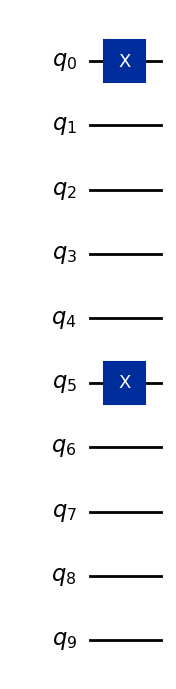

In [9]:
num_spatial_orbitals = mx.ncas
num_particles = mx.nelecas

hf_circuit = hartree_fock_circuit(num_spatial_orbitals, num_particles)
hf_circuit.draw(output="mpl", style="iqp")

### Step 1d. Define the operator pool
We define the set of operators as the single and double excitation operators generated by the UCC ansatz. These operators are also represented under the Jordan-Wigner transform. Note that this results in anti-Hermitian excitation operators, but we multiply them with the complex phase 1j later during the gradient calculation so that they appear Hermitian.

In [10]:
def single_excitation(
    num_spatial_orbitals: int, num_particles: tuple[int, int], mapping="jordan-wigner"
) -> list[SparsePauliOp]:
    """Compute single excitation operators under the Jordan-Wigner transform
    (up to complex coefficient 1j, such that they appear Hermitian instead of anti-Hermitian).
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        A list of single excitation operators under the Jordan-Wigner transform.
    """
    C, D = creators_destructors(2 * num_spatial_orbitals, mapping="jordan_wigner")

    num_alpha, num_beta = num_particles
    half_orbitals = num_spatial_orbitals
    indices_alpha = list(range(num_alpha))
    indices_beta = list(range(half_orbitals, (half_orbitals + num_beta)))

    single_excitation_operators = []

    for p in indices_alpha:
        for r in range(p + 1, half_orbitals):
            if r not in indices_alpha:
                exc = 1j * (C[p] @ D[r] - C[r] @ D[p]).simplify()
                single_excitation_operators.append(exc)

    for p in indices_beta:
        for r in range(p + 1, 2 * half_orbitals):
            if r not in indices_beta:
                exc = 1j * (C[p] @ D[r] - C[r] @ D[p]).simplify()
                single_excitation_operators.append(exc)

    return single_excitation_operators

In [11]:
def double_excitation(
    num_spatial_orbitals: int, num_particles: tuple[int, int], mapping="jordan-wigner"
) -> list[SparsePauliOp]:
    """Compute double excitation operators under the Jordan-Wigner transform
    (up to complex coefficient 1j, such that they appear Hermitian instead of anti-Hermitian).
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        A list of single excitation operators under the Jordan-Wigner transform.
    """
    C, D = creators_destructors(2 * num_spatial_orbitals, mapping="jordan_wigner")

    num_alpha, num_beta = num_particles
    half_orbitals = num_spatial_orbitals
    indices_alpha = list(range(num_alpha))
    indices_beta = list(range(half_orbitals, (half_orbitals + num_beta)))

    double_excitation_operators = []

    # Both excitations from alpha
    if len(indices_alpha) > 1:
        # from these indices
        for p in indices_alpha:
            for r in range(p + 1, num_alpha):
                # to these indices
                for a in range(indices_alpha[-1] + 1, half_orbitals):
                    for b in range(a + 1, half_orbitals):
                        exc = (
                            1j * (C[p] @ C[r] @ D[a] @ D[b] - C[b] @ C[a] @ D[r] @ D[p]).simplify()
                        )
                        double_excitation_operators.append(exc)

    # Both excitations from beta
    if len(indices_beta) > 1:
        # from these indices
        for p in indices_beta:
            for r in range(p + 1, half_orbitals + num_beta):
                # to these indices
                for a in range(indices_beta[-1] + 1, 2 * half_orbitals):
                    for b in range(a + 1, 2 * half_orbitals):
                        exc = (
                            1j * (C[p] @ C[r] @ D[a] @ D[b] - C[b] @ C[a] @ D[r] @ D[p]).simplify()
                        )
                        double_excitation_operators.append(exc)

    # One excitation from alpha, one from beta
    # from these indices
    for p in indices_alpha:
        for r in indices_beta:
            # to these indices
            for a in range(indices_alpha[-1] + 1, half_orbitals):
                for b in range(indices_beta[-1] + 1, 2 * half_orbitals):
                    exc = 1j * (C[p] @ C[r] @ D[a] @ D[b] - C[b] @ C[a] @ D[r] @ D[p]).simplify()
                    double_excitation_operators.append(exc)

    return double_excitation_operators

In [12]:
num_spatial_orbitals = mx.ncas
num_particles = mx.nelecas

single_excitation_operators = single_excitation(num_spatial_orbitals, num_particles)
double_excitation_operators = double_excitation(num_spatial_orbitals, num_particles)

excitation_pool = single_excitation_operators + double_excitation_operators
print(f"The excitation pool consists of {len(excitation_pool)} operators.")

The excitation pool consists of 24 operators.


---

## Step 2: Optimize problem for quantum execution
In the second step of the Qiskit Patterns framework we will prepare a workflow to optimize our circuits for execution on a backend. We start by first selecting a backend for execution:

In [13]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_algiers


Next we optimize the circuit for running on a real backend by customizing the preset staged pass manager with a few passes added to the `Scheduling` stage -- including a dynamical decoupling pass for error suppression.

In [14]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
# pm.scheduling = PassManager(
#     [
#         ALAPScheduleAnalysis(target=target),
#         ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
#         PadDynamicalDecoupling(
#             target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
#         ),
#     ]
# )

Now we use the pass manager on the initial state. We also need to apply the chosen device layout to the operators we will pass to the estimator primitive to measure expectation values. These variables will be used once we are ready to run on real hardware.

In [15]:
hf_circuit_transpiled = pm.run(hf_circuit)
molecular_hamiltonian_applied_layout = molecular_hamiltonian.apply_layout(hf_circuit_transpiled.layout)
excitation_pool_applied_layout = [exc.apply_layout(hf_circuit_transpiled.layout) for exc in excitation_pool]

---

## Qiskit Patterns Step 3: Execute using Qiskit Primitives
Before we execute on the selected hardware, it is a good idea to use a simulator for cursory debugging, and sometimes for estimates of error. For those reasons, we briefly show how to run ADAPT-VQE on a simulator. But it is critical to note that no classical computer, simulator or GPU can accurately simulate the full functionality of a highly-entangled 127-qubit quantum computer. In the present era of quantum utility, simulators will have limited use.

As a reminder the steps for execution are:

1. Compute the gradients by measuring the commutator between the Hamiltonian and each excitation operator in the pool.
2. Select the largest gradient and add the corresponding excitation operator to the ansatz.
3. Run VQE using the updated ansatz.

In the following sub-steps, we will walk through a single iteration of this loop. Once we have ensured each step is working correctly, we will put everything together to run on the entire workflow.

### Step 3a. Compute the gradients

We'll begin by first defining a function for the gradient calculation. This way we can call it whenever we need to compute the gradients during the overall ADAPT-VQE loop.

To actually calculate the gradients, we must measure the expectation value of the commutator between the Hamiltonian of the system and each operator in the excitation pool

$$ \frac{\partial E}{\partial \theta_i} = \langle \psi |[H,O_i]|\psi \rangle. $$

For this example, it is a total of 24 gradients that need to be computed.

In [16]:
def compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params=None):
    """
    Computes the gradients for all available excitation operators.
    Args:
        ansatz: ansatz built so far.
        hamiltonian: Hamiltonian after qubit mapping in SparsePauliOp format.
        excitation_pool: anti-Hermitian operators whose gradients need to be computed.
        estimator: an instance of the Qiskit Estimator primitive.
        params: parameters to be assigned to the ansatz, if any.
    Returns:
        List of computed gradients in the same order as the excitation operators in the excitation pool.
    """
    # The excitations operators are applied later as exp(i*theta*excitation).
    # For this commutator, we need to explicitly pull in the imaginary phase.
    # We recall that 1j was omitted earlier for the anti-Hermitian operators.
    commutators = [1j * (hamiltonian @ exc - exc @ hamiltonian) for exc in excitation_pool]

    # Prepare a PUB to submit to the estimator
    if params is not None:
        gradient_pub = [(ansatz, commutators, params)]
    else:
        gradient_pub = [(ansatz, commutators)]


    gradients = estimator.run(gradient_pub).result()
    gradients_list = []
    for pub_result in gradients:
        gradients_list.append(pub_result)

    return gradients_list

Next we will instantiate an `Estimator` and compute the gradients using our transpiled circuit and operators that we defined earlier.

In [18]:
estimator = Estimator(backend=backend)

Once initialized, we can then pass the `estimator` to our function which computes the gradients. Now we will compute the gradient of each operator in the excitation pool and select the operator with the largest gradient to append to the ansatz with a corresponding variational parameter.

In [19]:

gradients_pub = compute_gradients(hf_circuit_transpiled,             # Ansatz circuit
                              molecular_hamiltonian_applied_layout,  # Hamiltonian operators
                              excitation_pool_applied_layout,        # Excitation pool
                              estimator)                             # Estimator object to measure expectation values

gradients = gradients_pub[0].data.evs
# Find the maximum gradient amongst the commutator measurements
max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))
max_operator = excitation_pool[max_index]
print(f"Found operator with maximum gradient {max_gradient} at index {max_index}. \n{max_operator}")

Found operator with maximum gradient 0.25511421185389616 at index 23. 
SparsePauliOp(['YZZZYXZZZY', 'XZZZYYZZZY', 'XZZZXXZZZY', 'YZZZXYZZZY', 'XZZZYXZZZX', 'YZZZYYZZZX', 'YZZZXXZZZX', 'XZZZXYZZZX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j])


### Step 3b. Expand the Ansatz
Now that we have found the operator with the largest gradient in the pool, we will append it to the ansatz as $\textrm{exp}(i*\theta_0*O_n)$, where $\theta_0$ is the corresponding time evolution parameter. This will be our variational parameter to be optimized in the VQE step. Now we can easily time-evolve the selected operator by using the ``EvolvedOperatorAnsatz`` from Qiskit. Note that the operator to be complex exponentiated and evolved consists of summed Pauli operators. Therefore, the evolution parameter of this ansatz class can be specified to run with different methods such as ``LieTrotter``, ``SuzukiTrotter``, or exactly with ``MatrixExponential`` to test small problems.

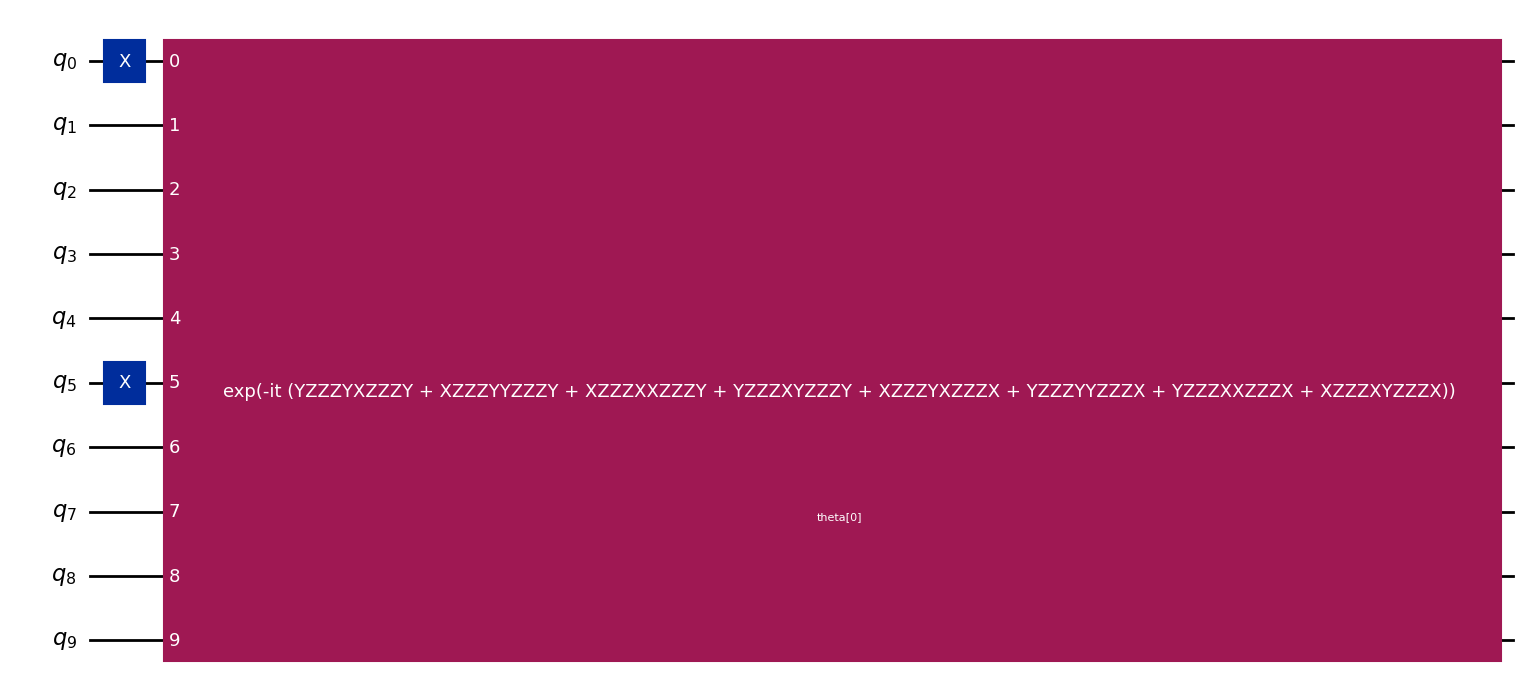

In [20]:

initial_ansatz = EvolvedOperatorAnsatz(
    operators=max_operator,
    evolution=LieTrotter(),
    parameter_prefix="theta",
    initial_state=hf_circuit,
)
initial_ansatz.decompose().draw(output="mpl", style="iqp")

Note that adding an operator to the ansatz does not drain the pool, i.e. the operator we added can again be selected in another iteration.

### Step 3c. Run VQE
We are now ready to run a VQE loop on the ansatz that we have so far. We'll first need to define our cost function, which in our case, is the expectation value of the molecular Hamiltonian.

In [17]:

def cost_func(params, ansatz, hamiltonian, estimator):
    energy = estimator.run([(ansatz, hamiltonian, params)]).result()[0].data.evs
    return energy


However, before running, we must ensure this new ansatz is transpiled and the new layout is applied to our operators.

In [24]:
initial_ansatz_transpiled = pm.run(initial_ansatz)
molecular_hamiltonian_applied_layout = molecular_hamiltonian.apply_layout(initial_ansatz_transpiled.layout)
excitation_pool_applied_layout = [exc.apply_layout(initial_ansatz_transpiled.layout) for exc in excitation_pool]

To begin the minimization, we'll start with a random guess for the parameter.

In [25]:
# Random start for the ansatz parameters
x0 = 2 * np.pi * np.random.random(initial_ansatz_transpiled.num_parameters)
print(x0)

[2.15169592]


And finally we classically optimize the $\theta_0$ parameter of our ansatz using the ``minimize`` function from ``scipy``. To do this efficiently, we'll invoke a `Session` and a new `Estimator` within that session so we're not waiting in the queue for each job.

In [28]:
with Session(backend=backend) as session:
    estimator_vqe = Estimator(session=session)
    # Print information about the session
    print(f"Session ID: {session.session_id}")
    print(f"Backend: {session.backend()}")

    # Run VQE loop
    results = minimize(
        cost_func,
        x0,
        args=(initial_ansatz_transpiled,
            molecular_hamiltonian_applied_layout,
            estimator_vqe),
        method="cobyla",
        options={"maxiter": 50, "disp": True},
    )
print(results)

Session ID: crqzdgpwpgrg0082j1wg
Backend: ibm_algiers

   Normal return from subroutine COBYLA

   NFVALS =   21   F =-6.296961E+00    MAXCV = 0.000000E+00
   X = 4.137924E+00
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.296961102067391
       x: [ 4.138e+00]
    nfev: 21
   maxcv: 0.0


### Step 3d. Update the ansatz

Now that we've obtained the results from the first VQE run, let's interpret the results and decide if we need another iteration of the algorithm.

We'll first collect the estimated ground state energy and value for $\theta_0$:

In [ ]:
# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = results.fun
print(f"Ground state energy estimate: {ground_energy}")

# Optimal parameters so far
theta_0 = results.x
print(f"Current list of optimal parameter(s): {theta_0}")

Ground state energy estimate: -6.296961102067391
Current list of optimal parameter(s): [4.13792404]


And then compute the gradients (i.e. the commutators between the Hamiltonian and our operator pool) again and their norm to determine if we should continue our algorithm.

In [ ]:
gradient_threshold = 1e-3

gradients_pub = compute_gradients(initial_ansatz_transpiled,
                              molecular_hamiltonian_applied_layout,
                              excitation_pool_applied_layout,
                              estimator,
                              params=theta_0)

gradients = gradients_pub[0].data.evs
gradient_norm = np.linalg.norm(np.abs(gradients))
max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))
max_operator = excitation_pool[max_index]

print(f"Found maximum gradient {max_gradient} at index {max_index}")
print(f"Is the gradient norm below the threshold? {gradient_norm < gradient_threshold}")
print(f"The operator that will be appended is: \n {max_operator}")

Found maximum gradient 0.07148198993249147 at index 11
Is the gradient norm below the threshold? False
The operator that will be appended is: 
 SparsePauliOp(['YZZZYIIIXY', 'XZZZYIIIYY', 'XZZZXIIIXY', 'YZZZXIIIYY', 'XZZZYIIIXX', 'YZZZYIIIYX', 'YZZZXIIIXX', 'XZZZXIIIYX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j])


Since the norm of the gradients is not below the threshold, we append the operator at the found index to the ansatz.

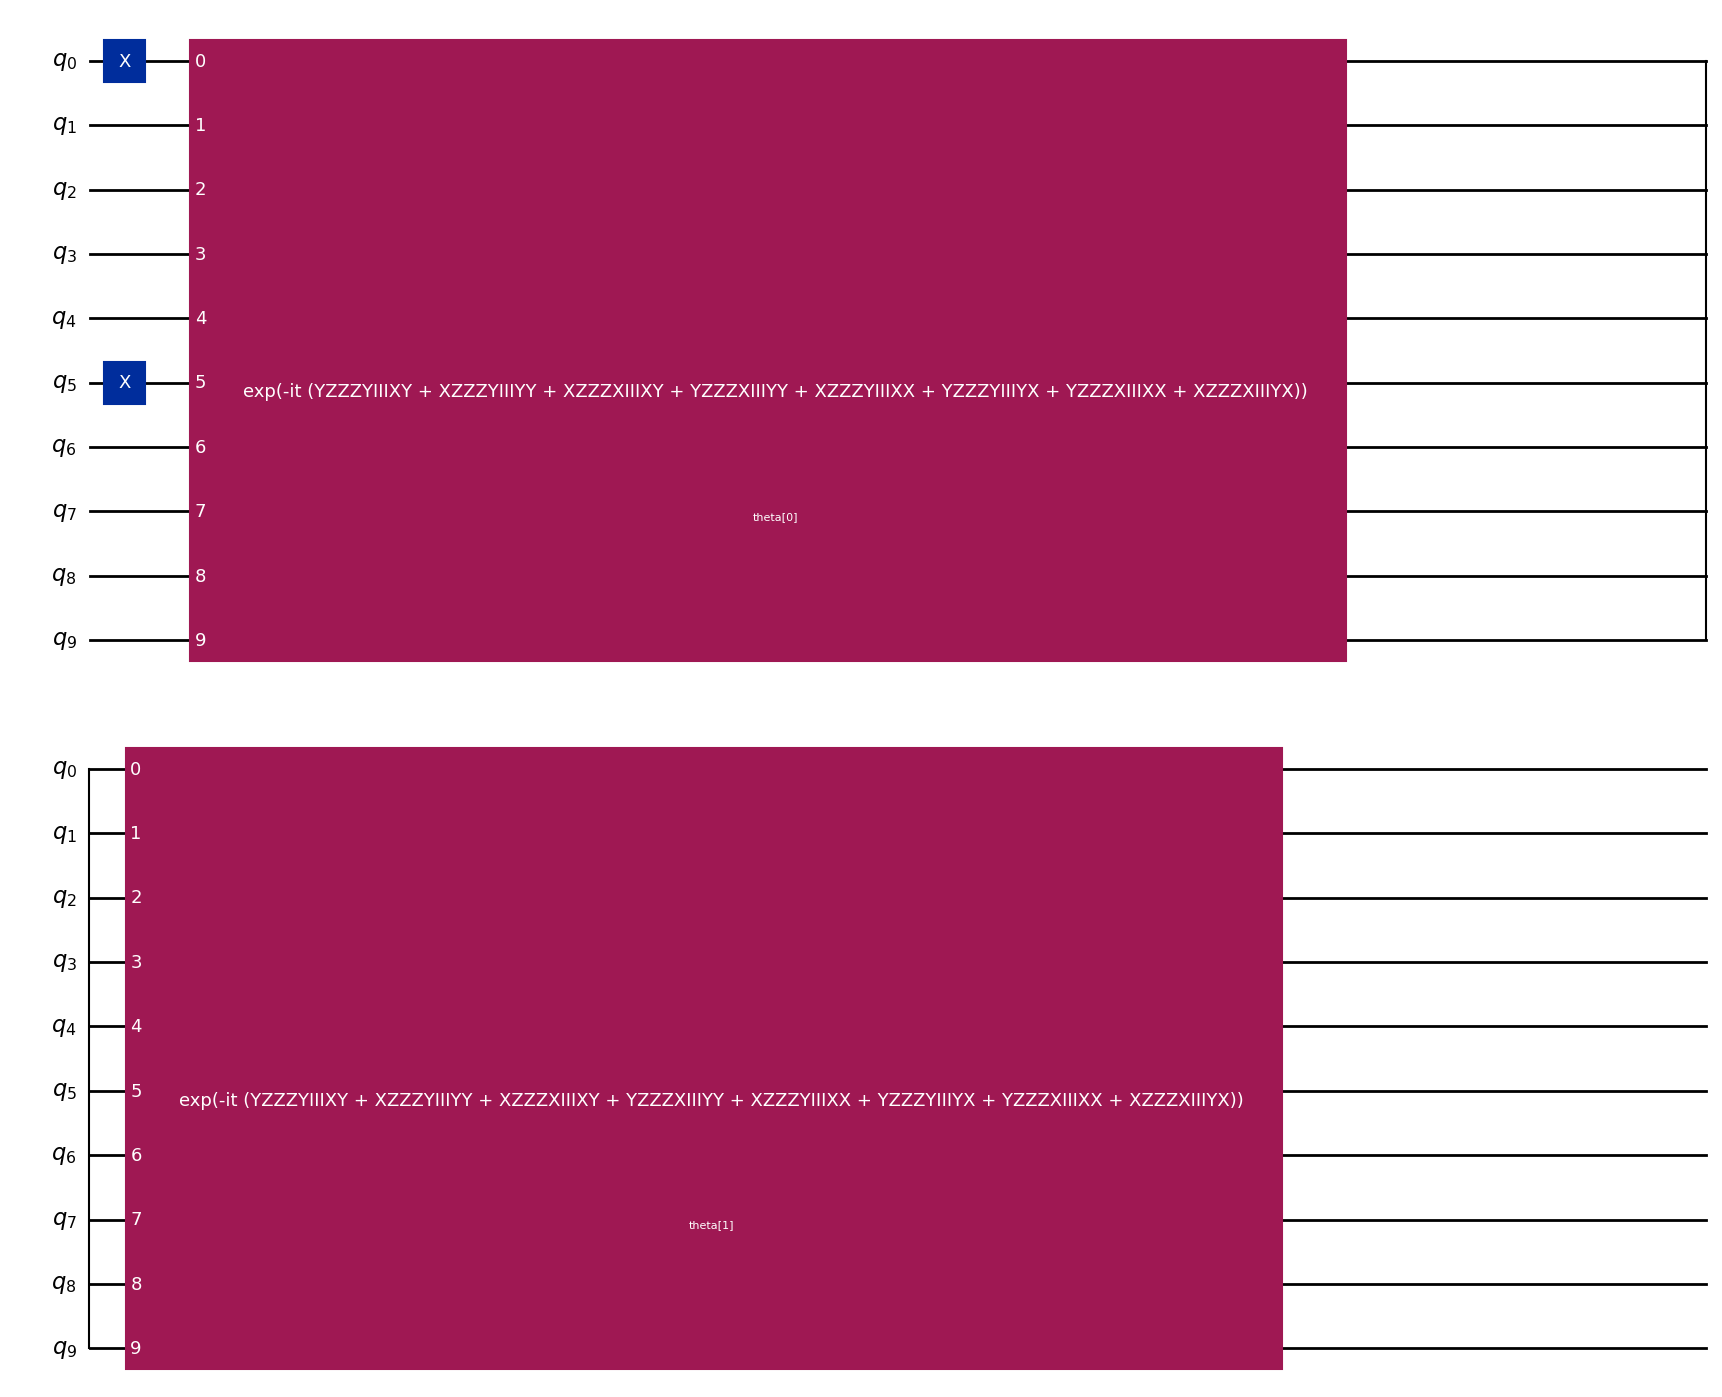

In [ ]:
# Initiate the list of operators with the first one
operator_list = [max_operator]

# Append the second operator
operator_list.append(excitation_pool[max_index])

updated_ansatz = EvolvedOperatorAnsatz(
    operators=operator_list,
    evolution=LieTrotter(),
    parameter_prefix="theta",
    initial_state=hf_circuit,
)
updated_ansatz.decompose().draw(output="mpl", style="iqp")

And repeat the VQE algorithm (we'll first need to transpile this new ansatz and run the optimization loop again within a `Session`):

In [ ]:
# Random start for the ansatz parameters
x0 = 2 * np.pi * np.random.random(updated_ansatz.num_parameters)
print(x0)

updated_ansatz_transpiled = pm.run(updated_ansatz)
molecular_hamiltonian_applied_layout = molecular_hamiltonian.apply_layout(updated_ansatz_transpiled.layout)
excitation_pool_applied_layout = [exc.apply_layout(updated_ansatz_transpiled.layout) for exc in excitation_pool]

with Session(backend=backend) as session:
    estimator_vqe = Estimator(session=session)
    res = minimize(
        cost_func,
        x0,
        args=(updated_ansatz_transpiled,
            molecular_hamiltonian_applied_layout,
            estimator_vqe),
        method="cobyla",
        options={"maxiter": 50, "disp": True},
    )
print(f"VQE Results:\n{res}")

# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = res.fun
print(f"Found ground state energy: {ground_energy}")

[2.90265515 3.56692645]
VQE Results:
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.953693060182523
       x: [ 2.838e+00  3.492e+00]
    nfev: 34
   maxcv: 0.0
Found ground state energy: -7.953693060182523

   Normal return from subroutine COBYLA

   NFVALS =   34   F =-7.953693E+00    MAXCV = 0.000000E+00
   X = 2.838074E+00   3.491960E+00


### Step 3d. Putting the steps together

Now that we have run one iteration of the ADAPT-VQE algorithm, we will combine all of these steps into a single loop. 

#### *(Optional) Run on a simulator*

If instead you wish to run this loop using a simulator, you can either use the `StateVectorEstimator` from `qiskit.primitives` or a fake backend from the `qiskit_ibm_runtime.fake_providers` module. If simulating using a fake provider, all that needs to be changed is the `backend` variable. And if running using the `StateVectorEstimator`, you'll need to replace the `estimator` variable with the state vector estimator.


Before we start the loop, we'll define some functions to serialize our results as the loop iterates. This way we can retrieve our data in case the loop fails.

In [18]:
# Define functions for serializing the results of the vqe loop
def serialize_vqe(results):
    json_dict = {}
    json_dict['message'] = results.message
    json_dict['success'] = str(results.success)
    json_dict['status'] = results.status
    json_dict['fun'] = results.fun
    json_dict['params'] = res.x.tolist()
    return json_dict

# Function to serialize the current ansatz
def serialize_ansatz(ansatz_list):
    json_list = []
    for operator in ansatz_list:
        paulis = []
        coeffs = []
        for i, pauli in enumerate(operator.paulis):
            paulis.append(str(pauli))
            coeffs.append(str(operator.coeffs[i]))
        json_list.append({"pauli":paulis, "coeffs":coeffs})
    return json_list

# Serialize the vqe results, ansatz, and gradients
def serialize_results(vqe_results, ansatz_list, gradients, gradient_norm):
    json_data = {}
    json_data['ansatz'] = serialize_ansatz(ansatz_list)
    json_data['vqe results'] = serialize_vqe(vqe_results)
    json_data['gradients'] = gradients.tolist()
    json_data['gradient norm'] = gradient_norm
    return json_data


This loop will be executed within a `Session` context and contains the following steps

1. Set the runtime conditions
2. Open a `Session`

    a. Instantiate an `Estimator`

    b. Prepare a pass manager

    c. Transpile the starting ansatz

    d. Compute the initial set of gradients and update the ansatz
    
    
3. Run the ADAPT-VQE Loop

    a. Transpile the updated ansatz

    b. Run the VQE optimization for this ansatz

    c. Compute the gradients using the optimal parameters

    d. Determine if the loop should conclude or continue. Update the ansatz if the loop will continue



In [19]:
# Define the conditions for termination
gradient_threshold = 1e-3
max_iter = 15
terminate = False


# Execute the ADAPT-VQE Loop within a context manager
with Session(backend=backend) as session:
    # Create the list of excitation operators that will be added to the ansatz
    operator_list = []

    # Choose a filename to store intermediate data and add a preamble with the run parameters
    fname = 'adapt-vqe-results.json'
    with open(fname, 'w+') as ofile:
        active_account = service.active_account()
        metadata = {"ADAPT-VQE Status":"Running",
                    "Service":service.active_account(),
                    "Session":session.details()}
        json.dump(metadata, ofile)

    # Print information about the session
    print(f"Session ID: {session.session_id}")
    print(f"Backend: {session.backend()}")

    # Instantiate the estimator primitive to use during the session, set
    #  the resilience level to incorporate error mitigation
    estimator_options = EstimatorOptions()
    estimator_options.default_shots = 5000
    estimator_options.resilience_level = 2
    estimator_options.optimization_level = 0
    estimator = Estimator(session=session, options=estimator_options)


    # Compute the initial set of gradients on hardware
    ansatz = pm.run(hf_circuit)
    molecular_hamiltonian_applied_layout = molecular_hamiltonian.apply_layout(ansatz.layout)
    excitation_pool_applied_layout = [exc.apply_layout(ansatz.layout) for exc in excitation_pool]

    # Compute the gradients, check if the norm of the gradients has converged
    gradients = compute_gradients(ansatz,
                                    molecular_hamiltonian_applied_layout,
                                    excitation_pool_applied_layout,
                                    estimator)
    gradients = gradients_pub[0].data.evs

    # Find the maximum gradient amongst the commutator measurements and compute the norm
    gradient_norm = np.linalg.norm(np.abs(gradients))
    max_gradient = np.max(np.abs(gradients))
    max_index = np.argmax(np.abs(gradients))
    max_operator = excitation_pool[max_index]
    print(f"Found operator with maximum gradient {max_gradient} at index {max_index}. \n{max_operator}")
    operator_list.append(max_operator)

    
    # Update the ansatz with the new operator list
    ansatz = EvolvedOperatorAnsatz(
        operators=operator_list,
        evolution=LieTrotter(),
        parameter_prefix="theta",
        initial_state=ansatz,
    )

    # Run the ADAPT-VQE loop
    iter = 0
    terminate = False
    while not terminate:
        print(32*"#")
        print(f"Iter: {iter}")
        # Transpile the updated ansatz circuit
        ansatz = pm.run(hf_circuit)
        molecular_hamiltonian_applied_layout = molecular_hamiltonian.apply_layout(ansatz.layout)

        # Execute the inner VQE loop
        x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
        print(f"Running VQE with initial ansatz: {x0}")
        res = minimize(
            cost_func,
            x0,
            args=(ansatz,
                  molecular_hamiltonian_applied_layout,
                  estimator),
            method="cobyla",
            options={"maxiter": 50, "disp": True}
            )

        # Note this returns the total energy, and we are often interested in the electronic energy
        ground_energy = res.fun
        params = res.x
        print(f"Result at iter: {iter}\n {res}")

         # Compute the initial set of gradients
        excitation_pool_applied_layout = [exc.apply_layout(ansatz.layout) for exc in excitation_pool]

        # Compute the gradients, check if the norm of the gradients has converged
        print(f"Computing Gradients...")
        gradients = compute_gradients(ansatz,
                                    molecular_hamiltonian_applied_layout,
                                    excitation_pool_applied_layout,
                                    estimator,
                                    params=params)
        gradients = gradients_pub[0].data.evs

        
        # Find the maximum gradient amongst the commutator measurements and compute the norm
        gradient_norm = np.linalg.norm(np.abs(gradients))
        max_gradient = np.max(np.abs(gradients))
        max_index = np.argmax(np.abs(gradients))
        max_operator = excitation_pool[max_index]
        print(f"Found operator with maximum gradient {max_gradient} at index {max_index}. \n{max_operator}")
        operator_list.append(max_operator)

        # Update the ansatz with the new operator list
        ansatz = EvolvedOperatorAnsatz(
            operators=operator_list,
            evolution=LieTrotter(),
            parameter_prefix="theta",
            initial_state=ansatz,
        )

        # Check if convergence condition has been met
        if gradient_norm < gradient_threshold:
            print(f"ADAPT-VQE Loop Succeeded! \nGround state energy found: {ground_energy}")
            print(f"For ansatz: {operator_list}")
            print(f"With corresponding parameters: {params}")
            terminate = True
        elif iter > max_iter:
            print(f"ADAPT-VQE Loop has not converged. Current parameters are:")
            print(f"Ground state energy: {ground_energy}")
            print(f"Ansatz operator List: {operator_list}")
            print(f"Parameters: {params}")
            terminate = True
        else:
            print(f"Saving intermediate results to file: {fname}")
            print()
            iter+=1

        # Save intermediate results to file
        with open(fname, 'r') as ofile:
            file_data = json.load(ofile)

        with open(fname, 'w') as ofile:

            file_data[f'Iter: {iter}'] = serialize_results(res, operator_list, gradients, gradient_norm)
            json.dump(file_data, ofile)

    # Save overall results to file
    with open(fname, 'r') as ofile:
        file_data = json.load(ofile)

    with open(fname, 'w') as ofile:
        file_data["ADAPT-VQE Status"] = "Complete"
        file_data['Final ADAPT-VQE Results'] = serialize_results(res, operator_list, gradients, gradient_norm)
        file_data['Total Iterations'] = iter
        json.dump(file_data, ofile)

Session ID: crr1pd1wpgrg0082jhgg
Backend: ibm_algiers


## Qiskit Patterns Step 4: Post-process, return result in classical format

Once the ADAPT-VQE loop has completed, we can examine the results that were obtained using the data file we just created. We can view the progress towards convergence at each iteration, as well as the final results.

In [29]:
with open(fname, 'r') as ofile:
    adapt_vqe_data = json.load(ofile)

final_results = adapt_vqe_data['Final ADAPT-VQE Results']


ground_energy = final_results['vqe results']['fun']
optimal_parameters = final_results['vqe results']['params']
ansatz_operators = final_results['ansatz']
print(f"Ground state energy estimate: {ground_energy}")
print(f"List of optimal parameter(s): {optimal_parameters} \n")
print(f"Final Ansatz used: \n {ansatz_operators}")

Ground state energy estimate: -6.296961102067391
Current list of optimal parameter(s): [4.13792404]


In [ ]:

# Grab the intermediate ground energies
ground_energies = []
for key, val in adapt_vqe_data.items():
    if 'Iter:' in key:
        vqe_results = adapt_vqe_data[key]['vqe results']
        ground_energies.append(vqe_results['fun'])

fig, ax = plt.subplots()
ax.plot(range(ground_energies), ground_energies)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()